# 🧠 Motion Classification Pipeline

This notebook contains the complete pipeline to classify human motion states (FALL, MOTION, NO_MOTION) using wearable sensor data. It includes:

1. Converting raw sensor data to Label Studio format
2. Annotating time-series using Label Studio
3. Post-processing labeled data
4. Feature extraction & classification

Let's begin!


## 🧹 Step 1: Process Raw Sensor Data for Label Studio

We will clean and format the raw BHI360 sensor output into a JSON format compatible with [Label Studio](https://labelstud.io/).


In [1]:
import pandas as pd
import numpy as np
import csv
import sys
import json
import logging
import matplotlib.pyplot as plt
import os
import requests
import json

from IPython.display import display
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from scipy.stats import kurtosis, skew
from scipy.fft import rfft
from scipy.signal import find_peaks


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [42]:
# CELL 2: Definitions from Block 2 (NoNaNJSONEncoder, csv_to_labelstudio_json)
class NoNaNJSONEncoder(json.JSONEncoder):
    """A custom JSON encoder that replaces NaN/Inf with None (i.e., null)."""
    def default(self, obj):
        if isinstance(obj, float):
            if np.isnan(obj) or np.isinf(obj):
                return None  # becomes 'null' in the final JSON
        return super().default(obj)

def csv_to_labelstudio_json(input_csv: str, output_json: str, skip_count: int = 4):
    """
    1) Reads the CSV (input_csv).
    2) Merges timestamps from:
       'sensortime_wakeup_ns' (unless '*') and
       'sensortime_nonwakeup_ns'.
    3) Renames sensor columns.
    4) Filters columns to keep only:
       {accel_x, accel_y, accel_z, gyro_x, gyro_y, gyro_z, timestamp_s}.
    5) Skips the first skip_count samples from each column.
    6) Builds the final JSON from remaining rows.
    7) Removes rows (in the final JSON) if any sensor column is '*'.
    8) Exports a single-task Label Studio–compatible JSON (output_json).
    """
    df = pd.read_csv(input_csv)

    df["timestamp_ns"] = df["sensortime_wakeup_ns"].mask(
        df["sensortime_wakeup_ns"] == "*",
        df["sensortime_nonwakeup_ns"]
    )
    df["timestamp_ns"] = pd.to_numeric(df["timestamp_ns"], errors="coerce")
    df["timestamp_s"] = df["timestamp_ns"] / 1e9

    rename_map = {
        "accelerometer_corrected_non_wakeup_ms2_x": "accel_x",
        "accelerometer_corrected_non_wakeup_ms2_y": "accel_y",
        "accelerometer_corrected_non_wakeup_ms2_z": "accel_z",
        "gyroscope_corrected_non_wakeup_dps_x": "gyro_x",
        "gyroscope_corrected_non_wakeup_dps_y": "gyro_y",
        "gyroscope_corrected_non_wakeup_dps_z": "gyro_z"
    }
    df.rename(columns=rename_map, inplace=True)

    columns_to_keep = [
        "accel_x", "accel_y", "accel_z",
        "gyro_x",  "gyro_y",  "gyro_z",
        "timestamp_s"
    ]
    df_filtered = df[columns_to_keep]
    df_skipped = df_filtered.iloc[skip_count:].reset_index(drop=True)

    sensor_cols = ["accel_x", "accel_y", "accel_z", "gyro_x", "gyro_y", "gyro_z"]
    valid_rows = []
    for _, row in df_skipped.iterrows():
        if any(str(row[col]) == '*' for col in sensor_cols):
            continue
        valid_rows.append(row)

    timeseries_dict = {col: [] for col in df_skipped.columns}
    for row in valid_rows:
        for col in df_skipped.columns:
            if col in sensor_cols:
                timeseries_dict[col].append(float(row[col]))
            else:
                timeseries_dict[col].append(row[col])

    tasks = [{"data": {"tsData": timeseries_dict}}]

    with open(output_json, "w") as f:
        json.dump(tasks, f, indent=2, cls=NoNaNJSONEncoder)

    display(f"Processed data (skipping first {skip_count} samples) saved to '{output_json}'.")


In [87]:
input_csv_path = "sensor_output/fall-13.csv"
output_json_path = "sensor_output/fall-13-formatted.json"
skip_count = 0
csv_to_labelstudio_json(
    input_csv=input_csv_path,
     output_json=output_json_path,
     skip_count=skip_count
)

"Processed data (skipping first 0 samples) saved to 'sensor_output/fall-13-formatted.json'."

## 🏷️ Step 2: Labeling in Label Studio


### 📄 Label Studio XML Configuration

Use this config when creating the project in Label Studio:

```xml
<View>
  <TimeSeriesLabels name="tsLabels" toName="ts">
    <Label value="FALL" background="red"/>
    <Label value="MOTION" background="#ffea00"/>
    <Label value="NO_MOTION" background="#05ff16"/>
  </TimeSeriesLabels>

  <TimeSeries name="ts" valueType="json" value="$tsData" timeColumn="timestamp_s" ordered="true">
    <Channel column="accel_x" legend="accel_x"/>
    <Channel column="accel_y" legend="accel_y"/>
    <Channel column="accel_z" legend="accel_z"/>
    <Channel column="gyro_x" legend="gyro_x"/>
    <Channel column="gyro_y" legend="gyro_y"/>
    <Channel column="gyro_z" legend="gyro_z"/>
  </TimeSeries>
</View>


## 🧹 Step 3: Processing Labeled Data

In the following cells, we process the labeled data exported from LabelStudio.


In [3]:
# === CONFIG ===
API_TOKEN = '38e2f475ec649852599b6bc81e4c7538177447e0'
API_URL = 'http://0.0.0.0:8080'
PROJECT_ID = 1  # Your 'Fall Detection' project
EXPORT_DIR = 'exported_tasks'
# ==============

os.makedirs(EXPORT_DIR, exist_ok=True)

headers = {
    'Authorization': f'Token {API_TOKEN}'
}

# Step 1: Get all tasks in the project
response = requests.get(
    f'{API_URL}/api/projects/{PROJECT_ID}/tasks',
    headers=headers
)

if response.status_code != 200:
    print("❌ Error fetching tasks:", response.text)
    exit()

tasks = response.json()

exported_count = 0

# Step 2: Export only annotated tasks
for task in tasks:
    annotations = task.get("annotations", [])
    if annotations:
        task_id = task['id']
        filename = os.path.join(EXPORT_DIR, f'task_{task_id}.json')
        with open(filename, 'w') as f:
            json.dump(task, f, indent=2)
        exported_count += 1

print(f"✅ Exported {exported_count} labeled tasks to '{EXPORT_DIR}'")

✅ Exported 20 labeled tasks to 'exported_tasks'


In [4]:
EXPORT_DIR = 'exported_tasks'
OUTPUT_CSV = 'training_data.csv'

rows = []

for filename in os.listdir(EXPORT_DIR):
    if filename.startswith("task_") and filename.endswith(".json"):
        filepath = os.path.join(EXPORT_DIR, filename)
        with open(filepath, 'r') as f:
            task = json.load(f)

        task_id = task['id']
        ts_data = task['data'].get('tsData', {})
        annotations = task.get('annotations', [])

        # === Parse annotation segments ===
        segments = []
        if annotations:
            try:
                for result in annotations[0].get('result', []):
                    value = result.get('value', {})
                    if 'start' in value and 'end' in value and 'timeserieslabels' in value:
                        segments.append({
                            'start': value['start'],
                            'end': value['end'],
                            'label': value['timeserieslabels'][0]  # assume single label per segment
                        })
            except Exception as e:
                print(f"❌ Error parsing annotation segments for task {task_id}: {e}")
                continue

        # === Extract time series ===
        accel_x = ts_data.get('accel_x', [])
        accel_y = ts_data.get('accel_y', [])
        accel_z = ts_data.get('accel_z', [])
        gyro_x = ts_data.get('gyro_x', [])
        gyro_y = ts_data.get('gyro_y', [])
        gyro_z = ts_data.get('gyro_z', [])
        timestamp_s = ts_data.get('timestamp_s', [])

        length = min(len(accel_x), len(accel_y), len(accel_z),
                     len(gyro_x), len(gyro_y), len(gyro_z), len(timestamp_s))

        if length == 0:
            print(f"⚠️  Warning: No time series data in task {task_id}")
            continue

        for i in range(length):
            ts = timestamp_s[i]
            label = "MOTION"  # Default to MOTION if not matched

            for segment in segments:
                if segment['start'] <= ts <= segment['end']:
                    label = segment['label']
                    break

            rows.append([
                accel_x[i], accel_y[i], accel_z[i],
                gyro_x[i], gyro_y[i], gyro_z[i],
                ts,
                label,
                task_id  # session_id
            ])

# === Sort by session_id (task_id) ===
rows.sort(key=lambda x: x[-1])  # last column is session_id

# === Write to CSV ===
with open(OUTPUT_CSV, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'timestamp_s', 'label', 'session_id'])
    writer.writerows(rows)

print(f"\n✅ CSV exported: '{OUTPUT_CSV}' with {len(rows)} rows, sorted by session_id.")



✅ CSV exported: 'training_data.csv' with 541539 rows, sorted by session_id.


## 🤖 Step 4: Feature Extraction and Model Training

We now extract statistical features from each window of time-series data and train a machine learning classifier.

Approach:
- Extract statistical/time/frequency-domain features
- Use SMOTE to handle class imbalance
- Use HistGradientBoostingClassifier
- Evaluate using Leave-One-Session-Out cross-validation

In [2]:
def read_data(csv_path):
    df = pd.read_csv(csv_path)
    df = df.sort_values(by=["session_id", "timestamp_s"]).reset_index(drop=True)
    return df

In [3]:
def compute_additional_features(vals, prefix="acc_x_"):
    if len(vals) == 0:
        return {
            f"{prefix}energy": np.nan,
            f"{prefix}zcr": np.nan,
            f"{prefix}iqr": np.nan
        }
    energy = np.sum(np.square(vals))
    zcr = (np.sum(np.diff(np.sign(vals)) != 0) / (len(vals) - 1)
           if len(vals) > 1 else np.nan)
    iqr = np.percentile(vals, 75) - np.percentile(vals, 25)
    return {
        f"{prefix}energy": energy,
        f"{prefix}zcr": zcr,
        f"{prefix}iqr": iqr
    }

In [4]:
def extract_advanced_features_from_timeseries(df_timeseries, window_size=2, step_size=0.25, do_fft=True):
    df = df_timeseries.copy()
    df["timestamp_s"] = df["timestamp_s"].astype(float)

    def safe_corr(a, b):
        return np.corrcoef(a, b)[0, 1] if len(a) > 1 else np.nan

    def compute_time_stats(vals, prefix="acc_x_"):
        if len(vals) == 0:
            return {
                f"{prefix}{stat}": np.nan
                for stat in [
                    "mean", "var", "skew", "kurt", "median",
                    "range", "rms", "p10", "p25", "p50", "p75"
                ]
            }
        return {
            f"{prefix}mean": np.mean(vals),
            f"{prefix}var": np.var(vals),
            f"{prefix}skew": skew(vals),
            f"{prefix}kurt": kurtosis(vals),
            f"{prefix}median": np.median(vals),
            f"{prefix}range": np.max(vals) - np.min(vals),
            f"{prefix}rms": np.sqrt(np.mean(vals**2)),
            f"{prefix}p10": np.percentile(vals, 10),
            f"{prefix}p25": np.percentile(vals, 25),
            f"{prefix}p50": np.percentile(vals, 50),
            f"{prefix}p75": np.percentile(vals, 75)
        }

    def compute_fft_stats(vals, prefix="acc_x_"):
        if len(vals) < 2:
            return {
                f"{prefix}fft_sum_amp": np.nan,
                f"{prefix}fft_peak_idx": np.nan
            }
        fft_vals = rfft(vals)
        mag = np.abs(fft_vals)
        return {
            f"{prefix}fft_sum_amp": np.sum(mag),
            f"{prefix}fft_peak_idx": np.argmax(mag)
        }

    all_windows = []
    for session_id in df["session_id"].unique():
        df_session = df[df["session_id"] == session_id]
        start_time = df_session["timestamp_s"].min()
        end_time = df_session["timestamp_s"].max()
        current_start = start_time

        while current_start <= end_time:
            current_end = current_start + window_size
            mask = (df_session["timestamp_s"] >= current_start) & (df_session["timestamp_s"] < current_end)
            df_w = df_session[mask]
            if len(df_w) > 0:
                ax, ay, az = df_w["accel_x"].values, df_w["accel_y"].values, df_w["accel_z"].values
                gx, gy, gz = df_w["gyro_x"].values, df_w["gyro_y"].values, df_w["gyro_z"].values
                acc_mag = np.sqrt(ax**2 + ay**2 + az**2)
                gyro_mag = np.sqrt(gx**2 + gy**2 + gz**2)

                stats = {}
                for prefix, vals in zip(
                    ["acc_x_", "acc_y_", "acc_z_", "gyro_x_", "gyro_y_", "gyro_z_"],
                    [ax, ay, az, gx, gy, gz]
                ):
                    stats.update(compute_time_stats(vals, prefix))
                    if do_fft:
                        stats.update(compute_fft_stats(vals, prefix))
                    stats.update(compute_additional_features(vals, prefix))

                stats.update(compute_time_stats(acc_mag, prefix="acc_mag_"))
                if do_fft:
                    stats.update(compute_fft_stats(acc_mag, prefix="acc_mag_"))
                stats.update(compute_additional_features(acc_mag, prefix="acc_mag_"))

                stats.update(compute_time_stats(gyro_mag, prefix="gyro_mag_"))
                if do_fft:
                    stats.update(compute_fft_stats(gyro_mag, prefix="gyro_mag_"))
                stats.update(compute_additional_features(gyro_mag, prefix="gyro_mag_"))

                stats.update({
                    "acc_xy_corr": safe_corr(ax, ay),
                    "acc_xz_corr": safe_corr(ax, az),
                    "acc_yz_corr": safe_corr(ay, az),
                    "gyro_xy_corr": safe_corr(gx, gy),
                    "gyro_xz_corr": safe_corr(gx, gz),
                    "gyro_yz_corr": safe_corr(gy, gz)
                })

                if len(acc_mag) > 0:
                    peak_idx = np.argmax(acc_mag)
                    peak_val = acc_mag[peak_idx]
                    time_to_peak = df_w["timestamp_s"].iloc[peak_idx] - current_start
                    median_val = np.median(acc_mag)
                    stats.update({
                        "acc_impact_peak_val": peak_val,
                        "acc_impact_time_to_peak": time_to_peak,
                        "acc_impact_median_diff": peak_val - median_val
                    })
                else:
                    stats["acc_impact_peak_val"] = np.nan
                    stats["acc_impact_time_to_peak"] = np.nan
                    stats["acc_impact_median_diff"] = np.nan

                jerk_x = np.diff(ax, prepend=ax[0])
                jerk_y = np.diff(ay, prepend=ay[0])
                jerk_z = np.diff(az, prepend=az[0])
                jerk_mag = np.sqrt(jerk_x**2 + jerk_y**2 + jerk_z**2)
                stats.update(compute_time_stats(jerk_mag, prefix="jerk_mag_"))
                stats.update(compute_additional_features(jerk_mag, prefix="jerk_mag_"))

                sma = np.sum(np.abs(ax) + np.abs(ay) + np.abs(az)) / len(ax)
                stats["sma"] = sma

                g = 9.81
                tilt_angle = np.clip(az / g, -1.0, 1.0)
                tilt_angle = np.arccos(tilt_angle)
                stats["tilt_angle_mean"] = np.mean(tilt_angle)
                stats["tilt_angle_std"] = np.std(tilt_angle)

                peaks, _ = find_peaks(acc_mag, height=np.mean(acc_mag) + np.std(acc_mag))
                stats["acc_num_peaks"] = len(peaks)

                label = df_w["label"].value_counts().idxmax()
                stats.update({
                    "start_time": current_start,
                    "end_time": current_end,
                    "label": label,
                    "session_id": session_id
                })
                all_windows.append(stats)
            current_start += step_size

    df_feat = pd.DataFrame(all_windows)
    df_feat.dropna(subset=["label"], inplace=True)
    return df_feat


In [5]:
csv_path = "training_data.csv"
df_raw = read_data(csv_path)
df_features = extract_advanced_features_from_timeseries(df_raw, window_size=2, step_size=0.25, do_fft=True)
print(f"Extracted {len(df_features)} windows.")


Extracted 8723 windows.


In [6]:
from sklearn.ensemble import HistGradientBoostingClassifier

def augment_with_noise(X, y, noise_level=0.01, num_copies=2):
    X_list = [X]
    y_list = [y]
    std_dev = X.std(axis=0, keepdims=True)
    for _ in range(num_copies):
        noise = np.random.normal(loc=0.0, scale=noise_level, size=X.shape)
        X_list.append(X + noise * std_dev)
        y_list.append(y)
    return np.concatenate(X_list, axis=0), np.concatenate(y_list, axis=0)

def loso_cv_print_each(df_features, feat_cols, model_params):
    sessions = df_features["session_id"].unique()
    session_results = []
    le = LabelEncoder()
    all_labels = sorted(df_features["label"].unique())
    le.fit(all_labels)
    print("Encoded classes order:", le.classes_)
    
    for test_session in sessions:
        train_df = df_features[df_features["session_id"] != test_session]
        test_df = df_features[df_features["session_id"] == test_session]
        
        X_train = train_df[feat_cols].values
        y_train = train_df["label"].values
        X_test = test_df[feat_cols].values
        y_test = test_df["label"].values
        
        imp = SimpleImputer(strategy="mean")
        X_train_imp = imp.fit_transform(X_train)
        X_test_imp = imp.transform(X_test)
        
        X_aug, y_aug = augment_with_noise(X_train_imp, y_train, noise_level=0.01, num_copies=2)
        sm = SMOTE(random_state=42)
        X_res, y_res = sm.fit_resample(X_aug, y_aug)
        
        y_res_enc = le.transform(y_res)
        y_test_enc = le.transform(y_test)
        
        model = HistGradientBoostingClassifier(random_state=42, **model_params)
        class_weights = {0: 1.0, 1: 1.0, 2: 1.0}
        sample_weights = np.array([class_weights[label] for label in y_res_enc])
    
        model.fit(X_res, y_res_enc, sample_weight=sample_weights)
        y_pred_enc = model.predict(X_test_imp)
        
        report = classification_report(y_test_enc, y_pred_enc, output_dict=True, zero_division=0)
        macro_f1 = report["macro avg"]["f1-score"]
        cm = confusion_matrix(y_test_enc, y_pred_enc, labels=range(len(le.classes_)))
        session_results.append((test_session, macro_f1, cm))
        
        print(f"\nSession {test_session} Confusion Matrix:")
        print(cm)
    
    return session_results, le, all_labels


In [7]:
def plot_row_normalized_confusion_matrix(cm, labels, title=""):
    """
    Displays a row-normalized confusion matrix in a 'Blues' colormap.
    """
    n = cm.shape[0]
    normalized_cm = np.zeros_like(cm, dtype=float)
    for i in range(n):
        row_sum = np.sum(cm[i, :])
        normalized_cm[i, :] = cm[i, :] / row_sum if row_sum > 0 else 0

    fig, ax = plt.subplots(figsize=(8, 6))
    # Use the 'Blues' cmap to match the original color style
    im = ax.imshow(normalized_cm, cmap="Blues", vmin=0, vmax=1)

    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    
    for i in range(n):
        row_sum = np.sum(cm[i, :]) if np.sum(cm[i, :]) > 0 else 1
        for j in range(n):
            percentage = (cm[i, j] / row_sum * 100)
            ax.text(j, i, f"{cm[i, j]}\n({percentage:.1f}%)",
                    ha="center", va="center", color="black")
    
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


def print_combined_metrics(cm, labels):
    n = cm.shape[0]
    total = np.sum(cm)
    accuracy = np.trace(cm) / total if total > 0 else 0
    precisions, recalls, f1s = [], [], []
    print("\nMetrics per class:")
    for i in range(n):
        TP = cm[i, i]
        FP = np.sum(cm[:, i]) - TP
        FN = np.sum(cm[i, :]) - TP
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        print(f"Class {labels[i]}: Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    
    macro_precision = np.mean(precisions)
    macro_recall = np.mean(recalls)
    macro_f1 = np.mean(f1s)
    print(f"\nOverall Accuracy: {accuracy:.4f}")
    print(f"Macro Precision: {macro_precision:.4f}, Macro Recall: {macro_recall:.4f}, Macro F1: {macro_f1:.4f}")


In [ ]:
def main():
    """
    Main function to run LOSO CV on the selected feature subset and 
    print overall results + combined confusion matrix.
    """
    # Example: we assume df_features is already created from previous steps
    selected_features = ['acc_mag_range', 'acc_mag_rms', 'acc_num_peaks', 'acc_x_range', 'gyro_mag_median']


    best_params = {'learning_rate': 0.01, 'max_iter': 200, 'max_leaf_nodes': 31}
    print(f"\nEvaluating selected feature combination: {selected_features}")
    session_results, le, labels = loso_cv_print_each(df_features, selected_features, best_params)
    
    combined_cm = np.zeros_like(session_results[0][2])
    for _, _, cm in session_results:
        combined_cm += cm
    
    print("\nCombined Confusion Matrix (All Sessions):")
    print(combined_cm)
    plot_row_normalized_confusion_matrix(combined_cm, labels, "Combined Confusion Matrix (Row-Normalized)")
    
    print_combined_metrics(combined_cm, labels)


In [ ]:
df_raw = read_data("training_data.csv")
df_features = extract_advanced_features_from_timeseries(df_raw, window_size=2, step_size=0.25, do_fft=True)
main()


## 📊 Step 5: Conclusions & Reporting

- Evaluated model performance using Leave-One-Session-Out (LOSO) cross-validation.
- Visualized class-wise prediction accuracy using row-normalized confusion matrices.
- Computed and reported overall accuracy, macro precision, recall, and F1-score.


In [ ]:
def main(num_runs=1): #Ideally, run 50 times. 
    """
    Runs the LOSO CV pipeline multiple times and aggregates macro-F1 scores
    and confusion matrices over all runs.

    Reports:
    - Mean ± std of macro F1-score
    - Total combined confusion matrix across all runs
    - Final evaluation metrics on the aggregated matrix
    """
    selected_features = ['acc_mag_range', 'acc_mag_rms', 'acc_num_peaks', 'acc_x_range', 'gyro_mag_median']
    best_params = {'learning_rate': 0.01, 'max_iter': 200, 'max_leaf_nodes': 31}
    
    print(f"🔁 Running LOSO CV {num_runs} times...")
    print(f"📊 Feature subset: {selected_features}")

    all_macro_f1 = []
    cumulative_cm = None
    labels = []

    for run in range(1, num_runs + 1):
        print(f"\n⚙️ Run {run}/{num_runs}")
        session_results, le, labels = loso_cv_print_each(df_features, selected_features, best_params)

        # Combine confusion matrix for this run
        run_cm = np.zeros_like(session_results[0][2])
        for _, _, cm in session_results:
            run_cm += cm

        # Initialize cumulative_cm if first run
        if cumulative_cm is None:
            cumulative_cm = run_cm
        else:
            cumulative_cm += run_cm

        macro_f1 = np.mean([f1 for _, f1, _ in session_results])
        all_macro_f1.append(macro_f1)
        print(f"➡️  Macro F1 (Run {run}): {macro_f1:.4f}")

    # Final metrics
    avg_f1 = np.mean(all_macro_f1)
    std_f1 = np.std(all_macro_f1)

    print("\n📈 Final Results over", num_runs, "runs:")
    print(f"✅ Macro F1-score: {avg_f1:.4f} ± {std_f1:.4f}")

    print("\n🧩 Combined Confusion Matrix (Aggregated Over All Runs):")
    print(cumulative_cm)
    plot_row_normalized_confusion_matrix(cumulative_cm, labels, "Aggregated Confusion Matrix (All Runs)")
    print_combined_metrics(cumulative_cm, labels)


🔁 Running LOSO CV 1 times...
📊 Feature subset: ['acc_mag_range', 'acc_mag_rms', 'acc_num_peaks', 'acc_x_range', 'gyro_mag_median']

⚙️ Run 1/1
Encoded classes order: ['FALL' 'MOTION' 'NO_MOTION']

Session 1 Confusion Matrix:
[[  0   0   0]
 [  0 106  44]
 [  0   3 226]]

Session 2 Confusion Matrix:
[[  0   0   0]
 [  0 290 144]
 [  0   0  56]]

Session 3 Confusion Matrix:
[[ 28   7   0]
 [ 12 122   1]
 [  3  59  90]]

Session 4 Confusion Matrix:
[[ 39   9   1]
 [  9 334  85]
 [  5  25 120]]

Session 5 Confusion Matrix:
[[ 23   1   0]
 [ 38 231   0]
 [  0  10  12]]

Session 6 Confusion Matrix:
[[  0   0   0]
 [  0 148  15]
 [  0  36 343]]

Session 7 Confusion Matrix:
[[ 0  0  0]
 [ 0 97  2]
 [ 0  1 54]]

Session 8 Confusion Matrix:
[[ 22  21   3]
 [  1  95   8]
 [  0   9 526]]

Session 9 Confusion Matrix:
[[  0   0   0]
 [  0 206  66]
 [  0  12 309]]

Session 10 Confusion Matrix:
[[ 36  18   0]
 [  5 161  26]
 [  3  51 387]]

Session 11 Confusion Matrix:
[[ 29   4   1]
 [ 39 297  13]
 [

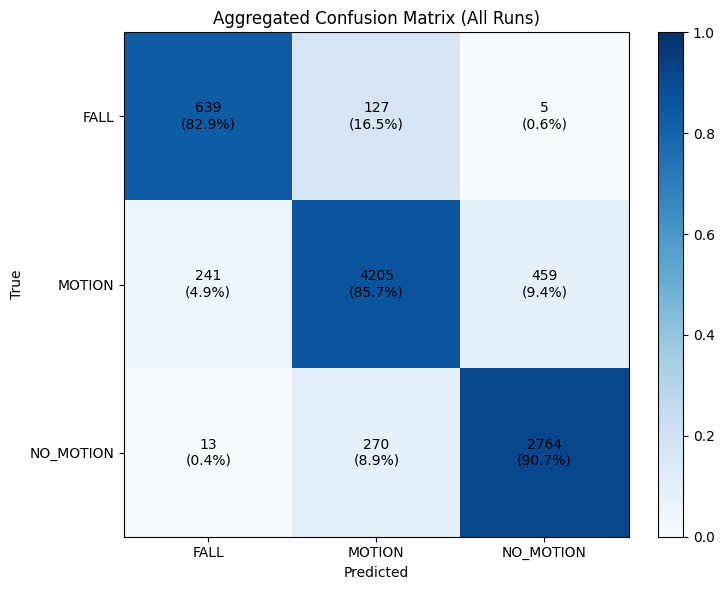


Metrics per class:
Class FALL: Precision: 0.7156, Recall: 0.8288, F1: 0.7680
Class MOTION: Precision: 0.9137, Recall: 0.8573, F1: 0.8846
Class NO_MOTION: Precision: 0.8563, Recall: 0.9071, F1: 0.8810

Overall Accuracy: 0.8722
Macro Precision: 0.8285, Macro Recall: 0.8644, Macro F1: 0.8445


In [9]:
df_raw = read_data("training_data.csv")
df_features = extract_advanced_features_from_timeseries(df_raw, window_size=2, step_size=0.25, do_fft=True)
main()
